In [15]:
import os
import numpy as np
import librosa
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import ast
import wandb
import torch.optim as optim
from featureblocks_16khz import FeatureBlock3

device = torch.device("cuda:2")

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# divide data into folds

model_name = "model_final_ala.torch"
num_epochs = 2000
frame_length = 16000
overlapping_fraction = 0.1
num_epochs = 1
data = torch.load('./torch_dataset_16khz/all_audio_data.pt')

# How many folds you want, bitch?
k_folds = 10
folds = []
step_size = int(len(data) / k_folds)

# Let's generate some folds baby!
for i in range(0, len(data), step_size):
    limit = i + step_size
    
    if limit > len(data):
        folds.append(data[i:])
    else:
        folds.append(data[i:limit])


In [11]:
# Load our dumbass model up
model = FeatureBlock3().to(device)

# This loss function gonna fuck us in the ass
loss_function = torch.nn.CrossEntropyLoss()

# This optimizer is the Jerry Smith of all optimizers.
optimizer = torch.optim.Adam(model.parameters(),lr=0.001, weight_decay=1e-5)

num_params = 0
for param in model.parameters():
    num_params += param.numel()

print(num_params)

374570


In [ ]:
# Let's start this ass spanking of a k-fold cross validation
for i in range(len(folds)):
    # fold i is the bitch fold here, we aren't touching this ass
    data = []
    for j in range(len(folds)):
        if i != j:
            data.extend(folds[j])
    
    # Set up the training data hoes
    data = torch.vstack(data)
    X_train = data[:,0:frame_length].clone()
    X_train = X_train.reshape(-1, 16,1000)
    Y_train = data[:,frame_length:].clone()
    
    audio_dataset = TensorDataset (X_train, Y_train)
    audio_dataloader = DataLoader (audio_dataset, batch_size = 250)
    
    model.train()
    
    print("#################################################################################################")
    print("#                                           FOLD {}                                              #".format(i))
    print("#################################################################################################")
    
    for epoch in range(num_epochs):
        running_loss=0
        correct=0
        total=0

        losses = []
        for index,(x,y) in enumerate(audio_dataloader):
            optimizer.zero_grad()
            
            y_hat = y.to(device)
            outputs = model(x.float().to(device))
            
            # Use argmax to get class with max probability value from softmax
            outputs = outputs.float()
            y_hat = y_hat.float()
            
            y_hat = y_hat.squeeze(1)
            loss = loss_function(outputs, y_hat)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_hat.size(0)
            correct += predicted.eq(y_hat).sum().item()

            accu=100.*correct/total
        
            print("iteration:{} loss:{} | Accuracy: {} ".format(iteration, loss.item(), accu=100.*correct/total))
            losses.append(loss.item())
            iteration += 1
            
         # calculate avg loss
        avg_loss = sum(losses) / len(losses)

        train_loss=running_loss/len(audio_dataloader)
        accu=100.*correct/total

        train_accu.append(accu)
        train_losses.append(train_loss)
        print("Epoch {} : Train Loss: {} | Accuracy: ".format(i,train_loss,accu))
        
        # This little bitch ass fold is gonna be our eval fold now
        # WHO'S YA PAPI NOW MAMA?
        data = folds[i]
        
        model.eval()
        
        running_loss=0
        correct=0
        total=0
        losses = []

        with torch.no_grad():

            for index,(x,y) in enumerate(audio_testloader):

                outputs = x.float()
                y_hat = y.type(torch.LongTensor)
                outputs = outputs.to(device)
                y_hat = y_hat.to(device)

                model.eval()
                outputs = model(outputs)
                y_hat = y_hat.squeeze(1)
                loss = loss_function(outputs, y_hat)

                running_loss += loss.item()
                _, predicted = outputs.max(1)
                total += y_hat.size(0)
                correct += predicted.eq(y_hat).sum().item()

                print("iteration:{} loss:{} correct: {} / {} ".format(iteration, loss.item(), correct, total))
                losses.append(loss)
                iteration += 1

        test_loss=running_loss/iteration
        accu=100.*correct/total

        eval_losses.append(test_loss)
        eval_accu.append(accu)

        print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    
    

In [69]:
import os
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import pandas as pd
import ast
from os import path
import math
import sys

class RMSLELoss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = torch.nn.MSELoss()
        
    def forward(self, pred, actual):
        return self.mse(torch.log(pred.float() + 1), torch.log(actual.float() + 1))

from featureblocks_16khz import FeatureBlock3


frame_length = 16000
overlapping_fraction = 0.1
data = torch.load('./folded_dataset_16khz/fold1.pt')


# Shuffle dataset before we do anything
#data=data[torch.randperm(data.size()[0])]
#X_train = data[:,0:frame_length].clone()
#test_portion = int(0.80*((data.size())[0]))

X_eval = data[:,0:frame_length].clone()
X_eval = X_eval.reshape(-1, 16, 1000)
Y_eval = data[:,frame_length:].clone()


audio_testset = TensorDataset (X_eval, Y_eval)
audio_testloader = DataLoader (audio_testset, batch_size = 50, shuffle= True)

test_accuracies = []
test_losses = []
for i in range(1, 11):
    model_name = "model_fold{}.pt".format(i)
    # The trinity of models
    model = FeatureBlock3().to(device)
    loss_function = torch.nn.CrossEntropyLoss()
    T_max = 500
    iteration = 0


    # Load model if exists
    if path.exists(model_name):
        checkpoint = torch.load(model_name, map_location=lambda storage, loc: storage.cuda(2))
        model.load_state_dict(checkpoint['model_state_dict'])
        #scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        best_loss = checkpoint['loss']
        print("Loaded model from {} with loss {}".format(model_name, checkpoint['loss']))

    model.eval()

    train_accu = []
    train_losses = []

    eval_losses=[]
    eval_accu=[]

    running_loss=0
    correct=0
    total=0
    losses = []

    with torch.no_grad():

        for index,(x,y) in enumerate(audio_testloader):

            outputs = x.float()
            y_hat = y.type(torch.LongTensor)
            outputs = outputs.to(device)
            y_hat = y_hat.to(device)

            model.eval()
            outputs = model(outputs)
            y_hat = y_hat.squeeze(1)
            #print("y size:{} outputs size:{}".format(y_hat.size(),outputs.size()))
            loss = loss_function(outputs, y_hat)


            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += y_hat.size(0)
            correct += predicted.eq(y_hat).sum().item()

            print("iteration:{} loss:{} correct: {} / {} ".format(iteration, loss.item(), correct, total))
            losses.append(loss)
            iteration += 1

    test_loss=running_loss/iteration
    accu=100.*correct/total

    eval_losses.append(test_loss)
    eval_accu.append(accu)

    print('Test Loss: %.3f | Accuracy: %.3f'%(test_loss,accu)) 
    test_accuracies.append(accu)
    test_losses.append(test_loss)


Loaded model from model_fold1.pt with loss 1.5268910595801024
iteration:0 loss:2.021749496459961 correct: 22 / 50 
iteration:1 loss:2.0450377464294434 correct: 43 / 100 
iteration:2 loss:2.1817328929901123 correct: 57 / 150 
iteration:3 loss:2.0585074424743652 correct: 77 / 200 
iteration:4 loss:2.2004051208496094 correct: 90 / 250 
iteration:5 loss:2.1024515628814697 correct: 108 / 300 
iteration:6 loss:2.2134640216827393 correct: 120 / 350 
iteration:7 loss:2.218045234680176 correct: 132 / 400 
iteration:8 loss:2.1407861709594727 correct: 148 / 450 
iteration:9 loss:2.1703293323516846 correct: 163 / 500 
iteration:10 loss:2.017130136489868 correct: 185 / 550 
iteration:11 loss:2.096034526824951 correct: 203 / 600 
iteration:12 loss:2.100111484527588 correct: 221 / 650 
iteration:13 loss:2.0910773277282715 correct: 239 / 700 
iteration:14 loss:2.1044247150421143 correct: 257 / 750 
iteration:15 loss:2.1004021167755127 correct: 275 / 800 
iteration:16 loss:2.076277732849121 correct: 29

In [70]:
test_accuracies

[33.745247148288975,
 74.7148288973384,
 74.49302915082383,
 72.52851711026616,
 70.65906210392902,
 72.78200253485424,
 71.98986058301648,
 60.93155893536122,
 66.57160963244614,
 74.90494296577947]

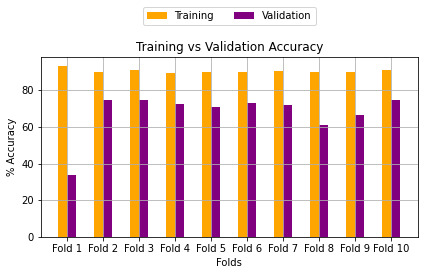

In [92]:
import matplotlib.pyplot as plt
import numpy as np


# Temporary renaming for test reasons
# when ready, make train_accuracies = accuraies you got from CSV
train_accuracies = [93.4603939350999, 90.18205001062549, 90.91623504197177, 89.42269742743353, 90.21801082929609,90.14386717788175,
                    90.39316721959483,90.01683737898134, 89.79699539105654, 91.21712150059939 ]
#fold7 90.39316721959483,
#fold8 90.01683737898134
#fold9 89.79699539105654
#fold10 91.21712150059939
labels = ['Fold 1', 'Fold 2', 'Fold 3', 'Fold 4','Fold 5', 'Fold 6', 'Fold 7', 'Fold 8', 'Fold 9','Fold 10']


x = np.arange(len(labels))  # the label locations
width = 0.25  # the width of the bars

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, train_accuracies, width, label='Training', color='orange')
rects2 = ax.bar(x + width/2, test_accuracies, width, label='Validation', color='purple')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Folds')
ax.set_ylabel('% Accuracy')
ax.set_title('Training vs Validation Accuracy')
ax.set_xticks(x)
ax.set_xticklabels(labels)
plt.legend(loc="lower center",bbox_to_anchor=(0.5, 1.15), ncol=2)
#figtext(.5,.9,'Foo Bar', fontsize=18, ha='center')

#ax.bar_label(rects1, padding=3)
#ax.bar_label(rects2, padding=3)

fig.tight_layout()
plt.grid()

plt.show()